In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import joblib
import time
import shap


In [3]:
# 1. Introducción y carga de datos
print("Cargando datos y modelos...")
df = pd.read_csv('../data/processed/data_toxic_features.csv')
X = df[['lemmatized_message', 'ofensivas_count']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

w2v_model = joblib.load('../models/w2v_model.joblib')
xgb_model = joblib.load('../models/xgb_optimized.joblib')
lgb_model = joblib.load('../models/lgb_optimized.joblib')

def get_doc_vector(doc, model):
    words = [word for word in doc if word in model.wv]
    if len(words) > 0:
        return np.mean(model.wv[words], axis=0)
    else:
        return np.zeros(model.vector_size)

X_test_w2v = np.array([get_doc_vector(doc.split(), w2v_model) for doc in X_test['lemmatized_message']])
X_test_w2v = np.column_stack((X_test_w2v, X_test['ofensivas_count'].values))


Cargando datos y modelos...


Evaluando XGBoost...
Evaluación del modelo XGBoost:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     57781
           1       0.97      0.93      0.95     38637

    accuracy                           0.96     96418
   macro avg       0.96      0.95      0.96     96418
weighted avg       0.96      0.96      0.96     96418



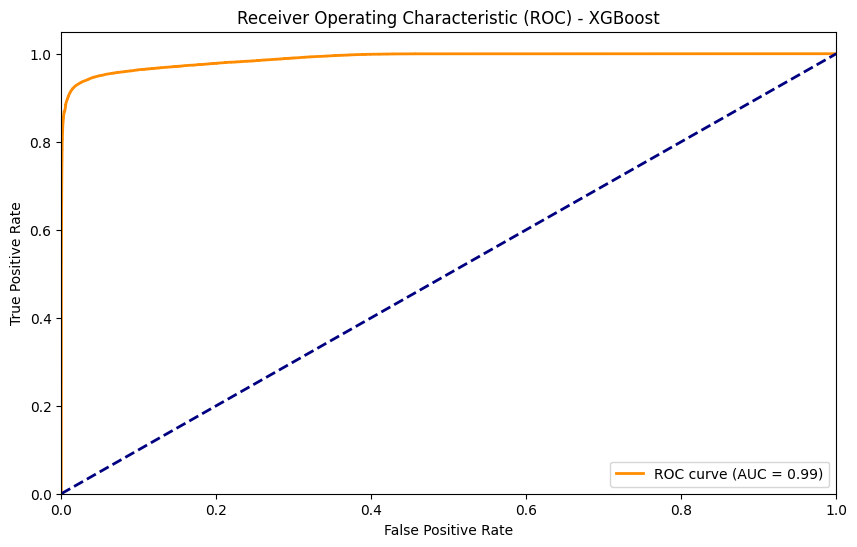


Evaluando LightGBM...
Evaluación del modelo LightGBM:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     57781
           1       0.97      0.93      0.95     38637

    accuracy                           0.96     96418
   macro avg       0.96      0.95      0.96     96418
weighted avg       0.96      0.96      0.96     96418



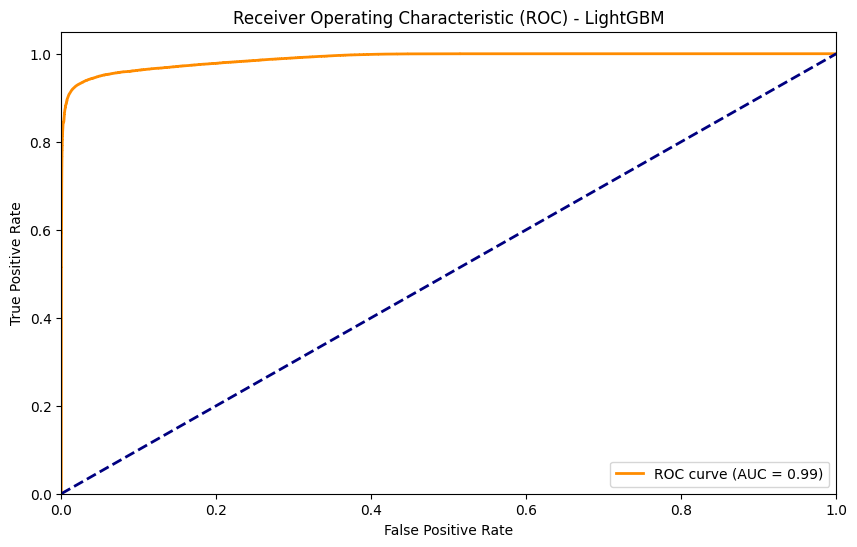

In [4]:
# 2. Evaluación detallada de métricas
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"Evaluación del modelo {model_name}:")
    print(classification_report(y_test, y_pred))
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

print("Evaluando XGBoost...")
evaluate_model(xgb_model, X_test_w2v, y_test, "XGBoost")

print("\nEvaluando LightGBM...")
evaluate_model(lgb_model, X_test_w2v, y_test, "LightGBM")

Analizando errores de XGBoost...

Análisis de errores para XGBoost:
true_label  predicted_label
0           1                  1177
1           0                  2728
dtype: int64


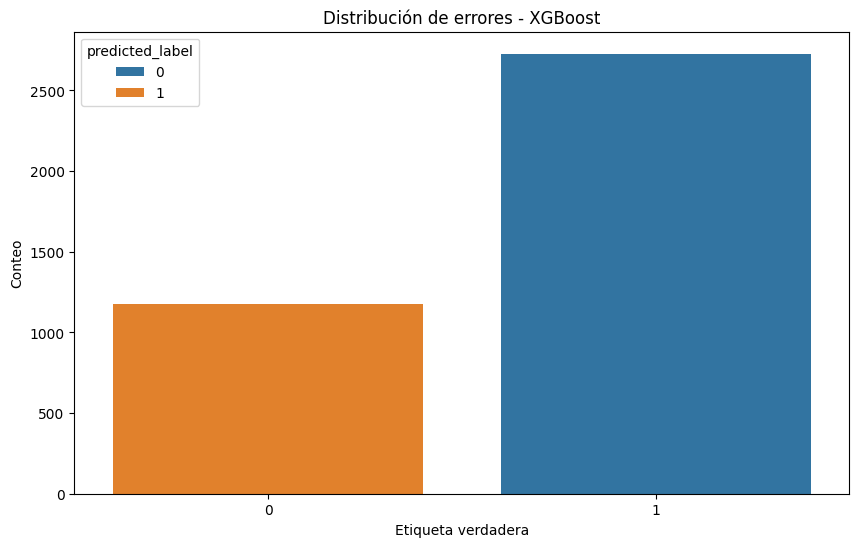


Analizando errores de LightGBM...

Análisis de errores para LightGBM:
true_label  predicted_label
0           1                  1192
1           0                  2753
dtype: int64


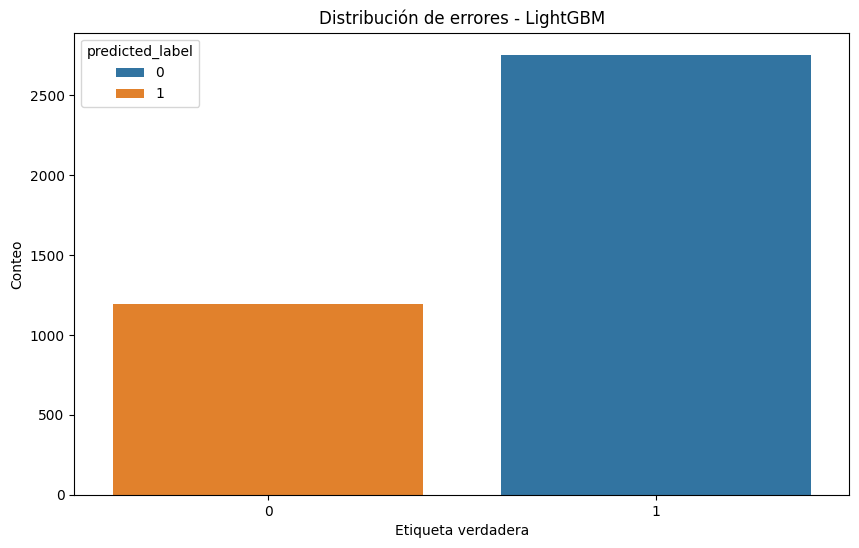

In [6]:
# 3. Análisis de errores
def analyze_errors(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    # Convertir a arrays numpy si no lo son ya
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    
    # Crear un DataFrame con los errores
    error_mask = y_test != y_pred
    errors = pd.DataFrame({
        'true_label': y_test[error_mask],
        'predicted_label': y_pred[error_mask]
    })
    
    print(f"\nAnálisis de errores para {model_name}:")
    print(errors.groupby(['true_label', 'predicted_label']).size())
    
    plt.figure(figsize=(10, 6))
    sns.countplot(x='true_label', hue='predicted_label', data=errors)
    plt.title(f'Distribución de errores - {model_name}')
    plt.xlabel('Etiqueta verdadera')
    plt.ylabel('Conteo')
    plt.show()

# Uso de la función
print("Analizando errores de XGBoost...")
analyze_errors(xgb_model, X_test_w2v, y_test, "XGBoost")

print("\nAnalizando errores de LightGBM...")
analyze_errors(lgb_model, X_test_w2v, y_test, "LightGBM")


Analizando importancia de características...


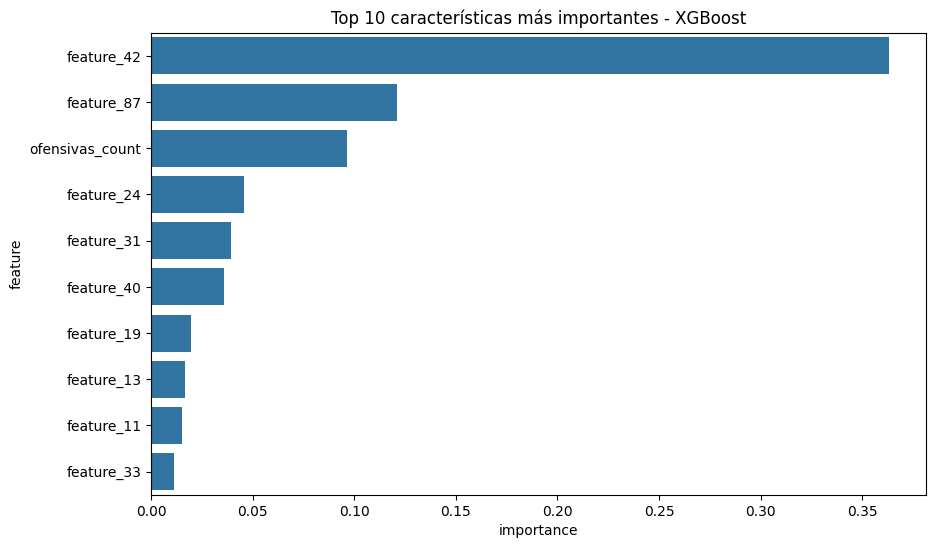

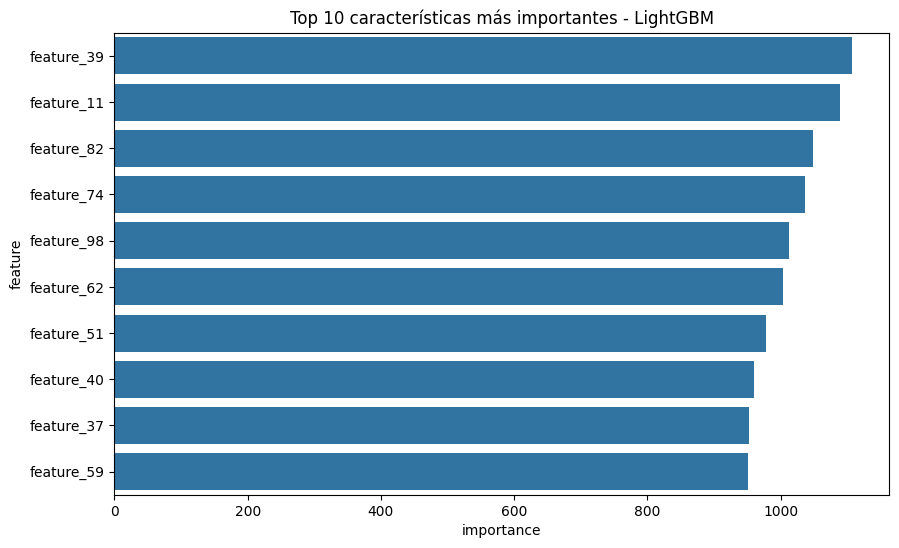

In [7]:
# 4. Interpretabilidad del modelo
def plot_feature_importance(model, model_name):
    feature_importance = model.feature_importances_
    feature_names = [f'feature_{i}' for i in range(100)] + ['ofensivas_count']
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
    importance_df = importance_df.sort_values('importance', ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance_df)
    plt.title(f'Top 10 características más importantes - {model_name}')
    plt.show()

print("Analizando importancia de características...")
plot_feature_importance(xgb_model, "XGBoost")
plot_feature_importance(lgb_model, "LightGBM")

Probando robustez de los modelos...


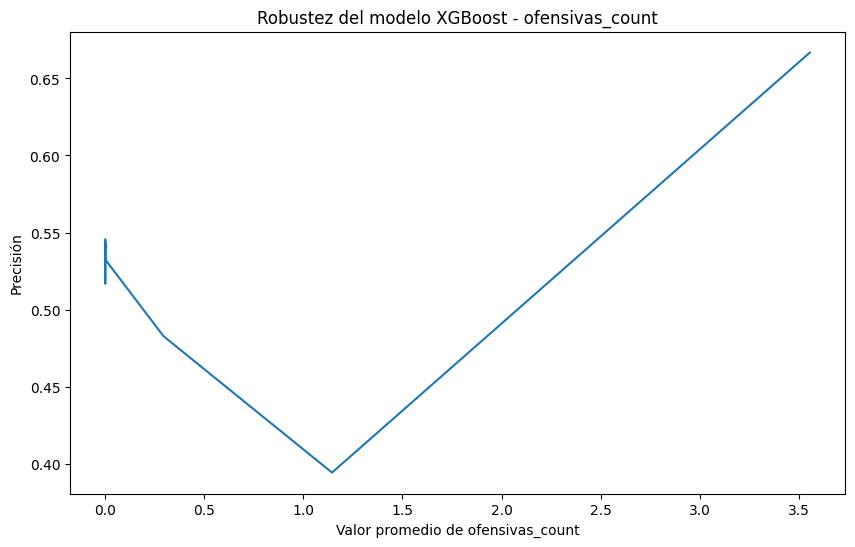

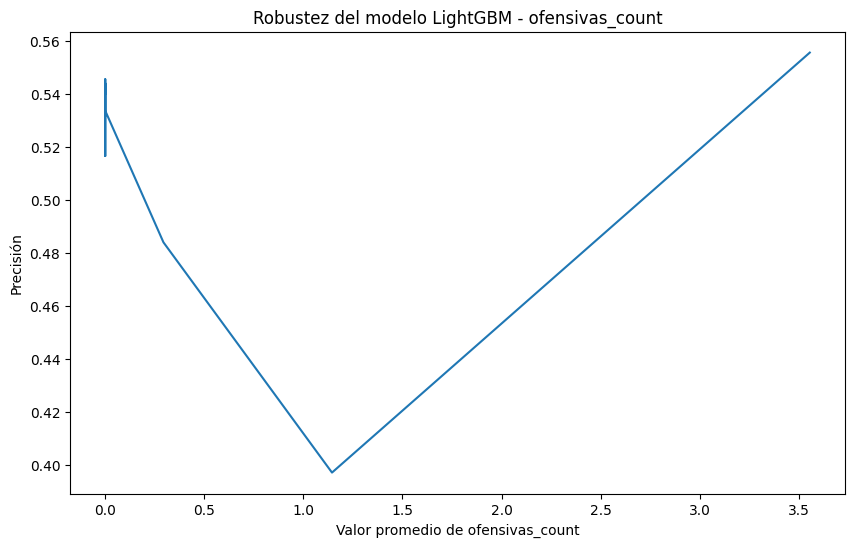

In [10]:
# 5. Pruebas de robustez
def test_robustness(model, X_test, y_test, X_test_w2v, feature, model_name):
    # Convertir a DataFrames si son arrays de NumPy
    if isinstance(X_test, np.ndarray):
        X_test = pd.DataFrame(X_test)
    if isinstance(y_test, np.ndarray):
        y_test = pd.Series(y_test)
    if isinstance(X_test_w2v, np.ndarray):
        X_test_w2v = pd.DataFrame(X_test_w2v)
    
    # Asegurarse de que todos los datos tienen el mismo índice
    common_index = X_test.index.intersection(y_test.index).intersection(X_test_w2v.index)
    X_test = X_test.loc[common_index]
    y_test = y_test.loc[common_index]
    X_test_w2v = X_test_w2v.loc[common_index]

    # Ordenar los datos por la característica especificada
    sorted_indices = X_test[feature].sort_values().index
    X_test_sorted = X_test.loc[sorted_indices]
    y_test_sorted = y_test.loc[sorted_indices]
    X_test_w2v_sorted = X_test_w2v.loc[sorted_indices]
    
    window_size = len(X_test) // 10
    accuracies = []
    feature_values = []
    
    for i in range(0, len(X_test), window_size):
        X_window = X_test_w2v_sorted.iloc[i:i+window_size]
        y_window = y_test_sorted.iloc[i:i+window_size]
        accuracy = model.score(X_window, y_window)
        accuracies.append(accuracy)
        feature_values.append(X_test_sorted[feature].iloc[i:i+window_size].mean())
    
    plt.figure(figsize=(10, 6))
    plt.plot(feature_values, accuracies)
    plt.title(f'Robustez del modelo {model_name} - {feature}')
    plt.xlabel(f'Valor promedio de {feature}')
    plt.ylabel('Precisión')
    plt.show()

print("Probando robustez de los modelos...")
test_robustness(xgb_model, X_test, y_test, X_test_w2v, 'ofensivas_count', "XGBoost")
test_robustness(lgb_model, X_test, y_test, X_test_w2v, 'ofensivas_count', "LightGBM")




In [11]:
# 6. Comparación de eficiencia computacional
def compare_efficiency(models, X_test):
    for name, model in models.items():
        start_time = time.time()
        model.predict(X_test)
        end_time = time.time()
        print(f"Tiempo de inferencia para {name}: {end_time - start_time:.4f} segundos")

print("\nComparando eficiencia computacional...")
compare_efficiency({'XGBoost': xgb_model, 'LightGBM': lgb_model}, X_test_w2v)



Comparando eficiencia computacional...
Tiempo de inferencia para XGBoost: 0.1928 segundos
Tiempo de inferencia para LightGBM: 0.4812 segundos
